In [31]:
### dimensionality reduction with PCA
## input: array of feature vectors
## output: array of feature vectors

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import os
import re

from io import BytesIO
from PIL import Image
import base64

from bokeh.plotting import figure, save, output_file
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Category10
from bokeh.palettes import Reds, Blues, Greens, Purples, Greys
from bokeh.io import output_file

from collections import defaultdict
from datetime import datetime
import json

###!!!!!
# 1. select extracted features
# 2. set PCA parameters
# 3. adjust run name
###!!!!!

In [32]:
# import features

feature_path = r"/home/tschernn/becore-clustering/pickles/features_hog.pkl"

with open(feature_path, 'rb') as file:
    image_features = pickle.load(file)

charter_list = r"/home/tschernn/becore-clustering/pickles/charter_list.pkl"
with open(charter_list, 'rb') as file:
    charters = pickle.load(file)

#feature_array = np.array(list(image_features.values()))
feature_array = image_features

feature_array.shape

(312, 8100)

In [33]:
### set colors for visualization

colors = {
    'papal': '#d73027',     # red
    'notary': '#1a9850',    # green
    'other': '#999999'      # grey
}

# Extract parent directories and simplify names after "writable_area_"
directories = [os.path.basename(os.path.dirname(path)).lower() for path in charters]
simplified_dirs = [re.sub(r'^.*writable_area_', '', d) for d in directories]

dir_categories = []
for d in simplified_dirs:
    name = d.lower()
    if 'papal' in name:
        dir_categories.append('papal')
    elif 'notary' in name:
        dir_categories.append('notary')
    else:
        dir_categories.append('other')

point_colors = [colors[cat] for cat in dir_categories]

In [34]:
## option 2: reduce dimensions for visualizations (2) and save plot

vis_settings = {
    "n_components": 2, # 2 dimensions for visualization
    "random_state": 42,
    "feature_extractor": "HOG",
    "preprocessing": "Binarization",
    "charter_selection": "French & Austrian (Papal, Notary, Other)",
    "special_highlighting": "no highlighted charters",
    "notes": "baseline HOG with very large cell & block size (64, 128) comparison with binarization"
}

# set up output directory with timestamp
run_name = "baseline_binary_xlhog_pca"
timestamp = datetime.now().strftime("%Y-%m-%d_%H%M")
output_dir = f"visualizations/{timestamp}_{run_name}"

os.makedirs(output_dir, exist_ok=True)

# save experiment dir with plot and settings
with open(os.path.join(output_dir, "settings.json"), "w") as f:
    json.dump(vis_settings, f, indent=4)
output_file(os.path.join(output_dir, "plot.html"))

### set PCA and keyword colors
pca = PCA(n_components = vis_settings['n_components'],
          random_state = vis_settings['random_state'])
pca.fit_transform(feature_array)
embedding = pca.transform(feature_array)

# convert to a DataFrame for bokeh
df = pd.DataFrame(embedding, columns=('x', 'y'))
df['label'] = [path.split('/')[-2] for path in charters]  # categorical labels for coloring

# === Define same-scribe prefixes ===
same_scribe_prefixes = ['0c0fb', 'e37dc', '08312', 'b1a27', '60234', '0c20d']

# other_scribe_prefixes = ['7e387', 'fa17d', '2a924', '155ec']

# === Create a flag for same-scribe samples ===
same_scribe_flag = [
    any(fname.split('/')[-1].startswith(prefix) for prefix in same_scribe_prefixes) 
    for fname in charters
]

# convert images to base64 for thumbnail display
def encode_image_to_base64(image_path):
    with Image.open(image_path) as img:
        img.thumbnail((100, 100))
        buffered = BytesIO()
        img.save(buffered, format="PNG")
        return base64.b64encode(buffered.getvalue()).decode()

# Extract parent directories and simplify names after "writable_area_"
directories = [os.path.basename(os.path.dirname(path)).lower() for path in charters]
simplified_dirs = [re.sub(r'^.*writable_area_', '', d) for d in directories]

#### create dots ####

# Extract filenames and encode images
filenames = [os.path.basename(path) for path in charters]
encoded_images = [f"data:image/png;base64,{encode_image_to_base64(path)}" for path in charters]
        
# create main data dict
data = dict(
    x = embedding[:, 0],
    y = embedding[:, 1],
    directory = simplified_dirs,
    filename = filenames,
    image = encoded_images,
    same_scribe = same_scribe_flag,
    color = point_colors
)

# split data into two ColumnDataSources
same_scribe_indices = [i for i, flag in enumerate(data['same_scribe']) if flag]
other_indices = [i for i, flag in enumerate(data['same_scribe']) if not flag]
same_scribe_source = ColumnDataSource({key: [data[key][i] for i in same_scribe_indices] for key in data})
normal_source = ColumnDataSource({key: [data[key][i] for i in other_indices] for key in data})

### display data
# create basic figure
p = figure(
    title=f'{vis_settings["charter_selection"]} - {vis_settings["preprocessing"]} - {vis_settings["feature_extractor"]} - PCA - {vis_settings["special_highlighting"]}',
    tools='pan,wheel_zoom,reset,hover,save',
    width=800,
    height=600)

# plot points (colored by directory)
p.scatter(
    'x', 'y',
    source=normal_source,
    legend_field='directory',
    color='color',
    alpha=0.7, size=8
)

# plot same-scribe charters (diamonds, red outline, same color inside)
p.scatter(
    'x', 'y',
    marker='diamond',
    source=same_scribe_source,
    size=12,
    line_color='red',
    fill_color='color',
    line_width=2,
    alpha=0.9,
    legend_label="Same Scribe Charters"
)

# add hover tool with embedded images
hover = HoverTool(tooltips="""
    <div>
        <div><strong>Filename:</strong> @filename</div>
        <div><img src="@image" alt="Image" style="width:100px;height:100px;"/></div>
    </div>
""")
p.add_tools(hover)

# create the legend
p.legend.title = 'Image Directories'
#p.legend.location = "best"
p.legend.click_policy = "hide"  # Allows toggling visibility of groups

save(p)

'/home/tschernn/becore-clustering/visualizations/2025-05-22_1314_baseline_binary_xlhog_pca/plot.html'

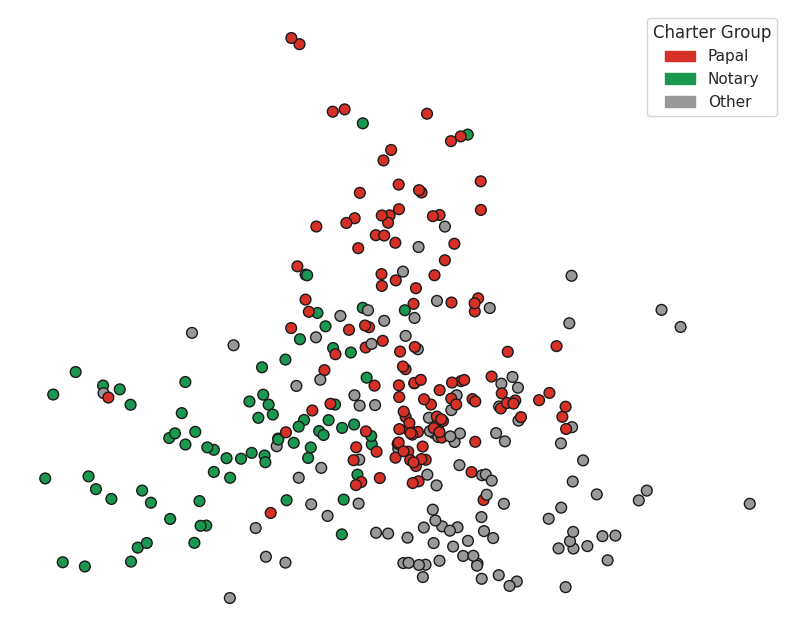

In [37]:
### create highres plot

plt.scatter(embedding[:, 0], embedding[:, 1], c=point_colors, s=60, edgecolors='k')
from matplotlib.patches import Patch

legend_items = [Patch(color=color, label=cat.capitalize()) for cat, color in colors.items()]
plt.legend(handles=legend_items, title="Charter Group")

plt.axis('off')

# Save as high-res PNG
plt.savefig(os.path.join(output_dir, "plot_highres.png"), dpi=300, bbox_inches='tight')